# European Airbnb Listing Price Analysis - a Report

## Preliminary Data Loading

In [2]:
options(tidyverse.quiet = TRUE);
suppressPackageStartupMessages(library(tidyverse));
suppressPackageStartupMessages(library(tidymodels));
suppressPackageStartupMessages(library(GGally));
# Cities are, amsterdam, athens, barcelona, berlin, budapest, lisbon, london, paris, rome, vienna, days are weekdays, weekends
url_first <- "https://zenodo.org/record/4446043/files/"
cities <- c("amsterdam", "athens", "barcelona", "berlin", "budapest", "lisbon", "london", "paris", "rome", "vienna");
total_dataset <- tibble()

download.wrapper <- function(file) {
    dir.create("./data/", showWarnings = FALSE); # don't care if it's present
    file.loc <- paste("./data/",file,sep="")
    if (!file.exists(file.loc)) {
        Sys.sleep(0.5) # don't overload their server
        download.file(paste(url_first, file, sep=""), destfile = file.loc)
    }
    return(read_csv(file.loc))
}

for (i in 1:10) {
    sub_data <- download.wrapper(paste(cities[i], "_weekdays.csv", sep ="")) |>
        mutate(city = cities[i]) |>
        mutate(day = "weekday") |>
        suppressMessages()
    sub_data_end <- download.wrapper(paste(cities[i], "_weekends.csv", sep ="")) |>
        mutate(city = cities[i]) |>
        mutate(day = "weekend") |>
        suppressMessages()
    
    total_dataset <- bind_rows(total_dataset, sub_data, sub_data_end)
}

In [25]:
set.seed(420);

# clean data
airbnb_clean <- total_dataset |>
    select(-1) |> #some incrementing number
# according to https://zenodo.org/record/4446043#.Y9Y9ENJBwUE these columns are dummies:
    select(-room_private, -room_shared) |>
# apparently these are already scaled to [0,100] - drop the duplicate
    select(-attr_index, -rest_index) |>
    mutate(room_type = as_factor(room_type)) |>
    mutate(city = as_factor(city), day = as_factor(day), multi = as_factor(multi), biz = as_factor(biz)) |>
    rename(dist_from_city_centre = dist,
           cost = realSum,
           attraction_index = attr_index_norm,
           restaurant_index = rest_index_norm)

airbnb_clean |>
    select(room_type) |>
    pull() |>
    levels()

airbnb_split <- initial_split(airbnb_clean, prop = 0.75, strata = room_type)
airbnb_train <- training(airbnb_split)
airbnb_test <- testing(airbnb_split)

glimpse(airbnb_train)

[1] "Private room"    "Entire home/apt" "Shared room"

Rows: 38,779
Columns: 17
$ cost                       <dbl> 2771.3074, 1001.8044, 675.6028, 933.8458, 1…
$ room_type                  <fct> Entire home/apt, Entire home/apt, Entire ho…
$ person_capacity            <dbl> 4, 4, 4, 4, 4, 2, 4, 3, 4, 4, 5, 3, 2, 2, 4…
$ host_is_superhost          <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FA…
$ multi                      <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ biz                        <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ cleanliness_rating         <dbl> 10, 9, 8, 10, 9, 9, 9, 10, 9, 10, 10, 10, 1…
$ guest_satisfaction_overall <dbl> 100, 96, 87, 96, 96, 89, 100, 100, 94, 94, …
$ bedrooms                   <dbl> 3, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2…
$ dist_from_city_centre      <dbl> 1.6868070, 3.7191414, 2.9330458, 1.0140664,…
$ metro_dist                 <dbl> 1.4584036, 1.1961124, 0.6280730, 0.3771037,…
$ attraction_index           <dbl> 11.056528, 5.624761, 11.380334, 25.299513, …
$ restaurant_in

## Introduction

#! should've trimmed this down!!

Europe is the most traveled region in the world (UNWTO, 2023) and there are many countries to explore. In order to have the most enjoyable trip, proper planning and budgeting is required. Airbnb is one of the most popular ways to find accommodation while you travel. Hence, we would like to determine what factors determine the price of an Airbnb listing in ten most popular European cities, how strongly they affect Airbnb listing prices, and build a model that predicts the price given properties about the listing. By performing multivariable linear regression, we will address these predictive statements: What   categorical and numerical factors or predictors exhibit significant correlation with Airbnb room prices? From this, we will use Airbnb determinants that have significant relationship (consider strength and direction) with pricing to predict the cost of an Airbnb room in Europe. The dataset we will use is from a study published in Tourism Management titled, “Determinants of Airbnb prices in European cities: A spatial econometrics approach” (Gyódi & Nawaro, 2021). These datasets are separated by city and type of day and contains numerical determinants such as ‘person_capacity’, ‘cleanliness_rating’, ‘bedrooms’ and categorical determinants such as ‘room_type’ and other determinants of Airbnb prices. The variable, ‘realSum’, is the total price of Airbnb listing, which will be predicted using linear regression by analyzing its relationships with Airbnb determinants.

## Methods and Results
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
  - loads data from the original source on the web 
  - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
  - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
  - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
  - performs the data analysis
  - creates a visualization of the analysis 
  - note: all tables and figure should have a figure/table number and a legend

We first analyze the distribution of the cost itself.

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   34.78   148.88   211.11   279.72   319.62 16445.62 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 188 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


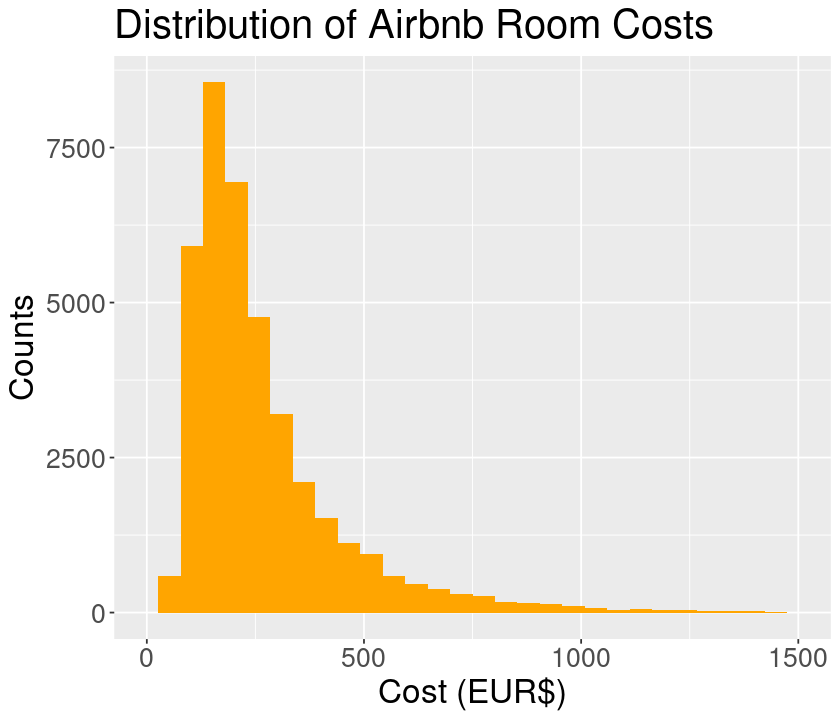

In [23]:
options(repr.plot.width = 7, repr.plot.height = 6)

airbnb_train |>
    select(cost) |>
    pull() |>
    summary()

ggplot(airbnb_train, aes(x=cost)) +
    geom_histogram(fill="orange") +
    xlim(0,1500) +
    labs(x="Cost (EUR$)", y="Counts", title="Distribution of Airbnb Room Costs") +
    theme(text = element_text(size = 20))

We see that the cost has a strong right skew, with an average price of about \\$280.

Next, we analyze the distribution of the cost in relation to categorical variables, to see what categorical variables will be useful in the analysis.

Warning message:
“attributes are not identical across measure variables; they will be dropped”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 8322 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 38 rows containing missing values (`geom_path()`).”


Rows: 38,779
Columns: 7
$ cost              <dbl> 2771.3074, 1001.8044, 675.6028, 933.8458, 1032.9717,…
$ room_type         <fct> Entire home/apt, Entire home/apt, Entire home/apt, E…
$ host_is_superhost <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ multi             <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0…
$ biz               <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city              <fct> amsterdam, amsterdam, amsterdam, amsterdam, amsterda…
$ day               <fct> weekday, weekday, weekday, weekday, weekday, weekday…


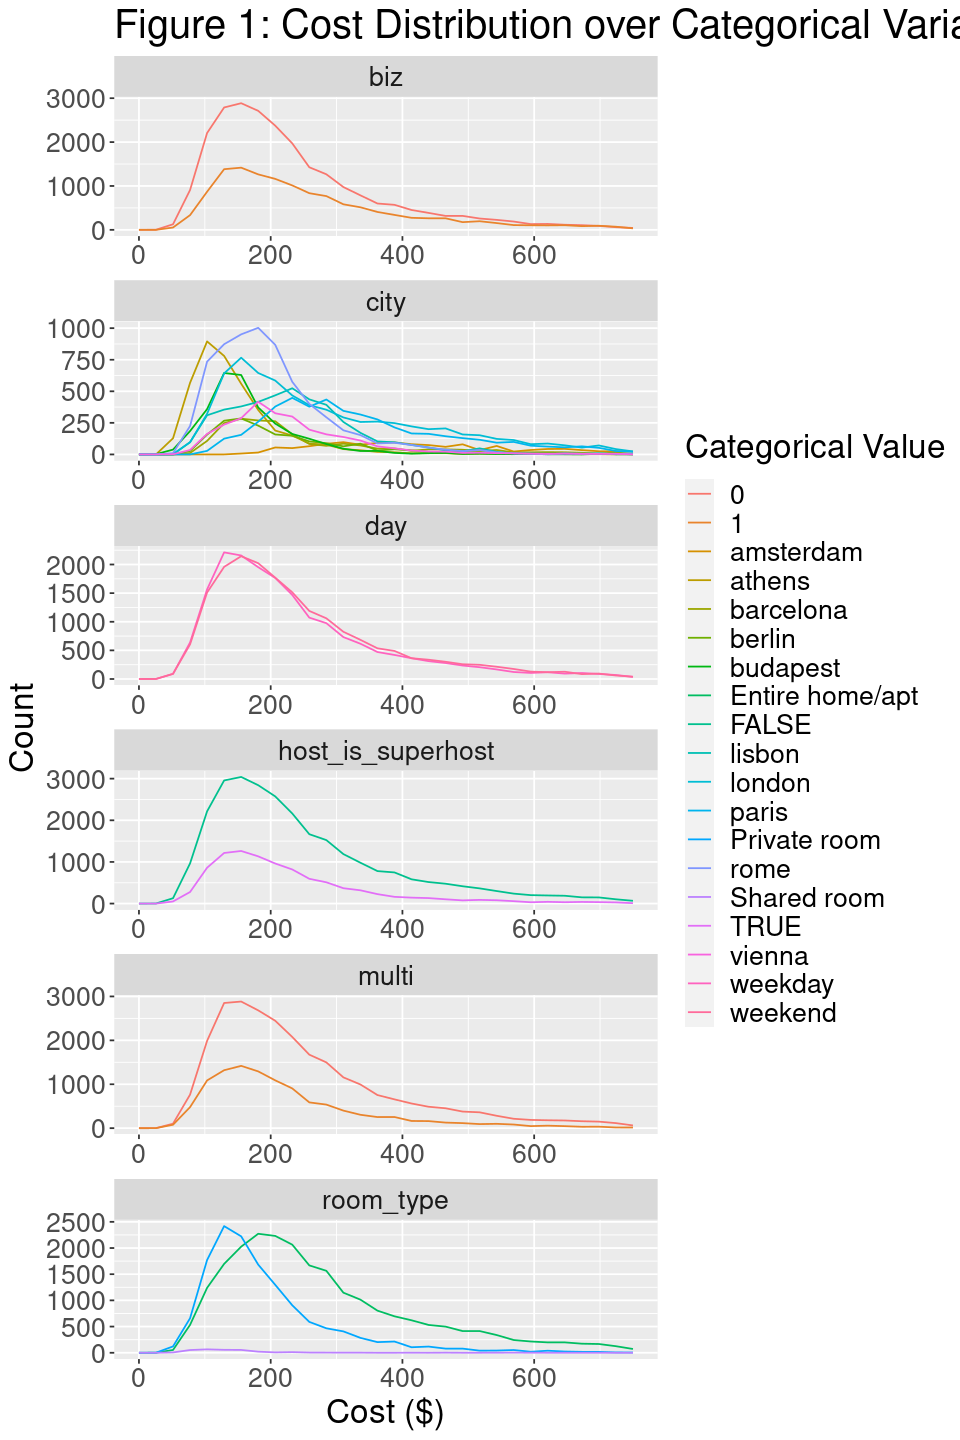

In [20]:
#############################################              #############################################
############################################# TODO CLEANUP #############################################
#############################################              #############################################

options(repr.plot.width = 8, repr.plot.height = 12)

airbnb_categorical <- airbnb_train |>
    select(-person_capacity, -cleanliness_rating, -guest_satisfaction_overall, -bedrooms, -dist_from_city_centre, -metro_dist, -attraction_index, -restaurant_index, -lng, -lat)

# https://stackoverflow.com/questions/24648729/plot-one-numeric-variable-against-n-numeric-variables-in-n-plots
# can't use ggpairs since we only want against ONE variable
# also ggpairs takes ages + only numeric lol
airbnb_categorical |>
    gather(-cost, key = "variable", value = "value") |>
    ggplot(aes(cost, color = value)) + 
        geom_freqpoly() +
        facet_wrap(~variable, scales = "free", ncol = 1) +
        xlim(0,750) + # want smaller axes
        labs(x = "Cost ($)", y = "Count", color = "Categorical Value", title = "Figure 1: Cost Distribution over Categorical Variables") +
        theme(text = element_text(size = 20))

glimpse(airbnb_categorical);

From this, we can determine a few things. Firstly, whether the host is a superhost, the day of the week the data was taken, whether the host is a 'multi-host' or a business does not affect the price, as they each have the same distribution (just with lower counts). However, we notice that the room type and the city clearly has an impact on the price. Thus, we can filter out all categorical variables except the room type and city.

Secondly, the distribution is skewed with a heavy right tail, suggesting that either there are more relatively expensive properties than there are very cheap ones or there are outliers (i.e. rather unusually expensive homes) present in the data.

Next, we analyze the numerical variables' distributions versus cost. Note we do not analyze longitude and latitude as that should not have an impact on the cost that is not independent from other included factors, such as the distance from city centre and distance from metro areas.

Warning message:
“Removed 168 rows containing missing values (`geom_point()`).”


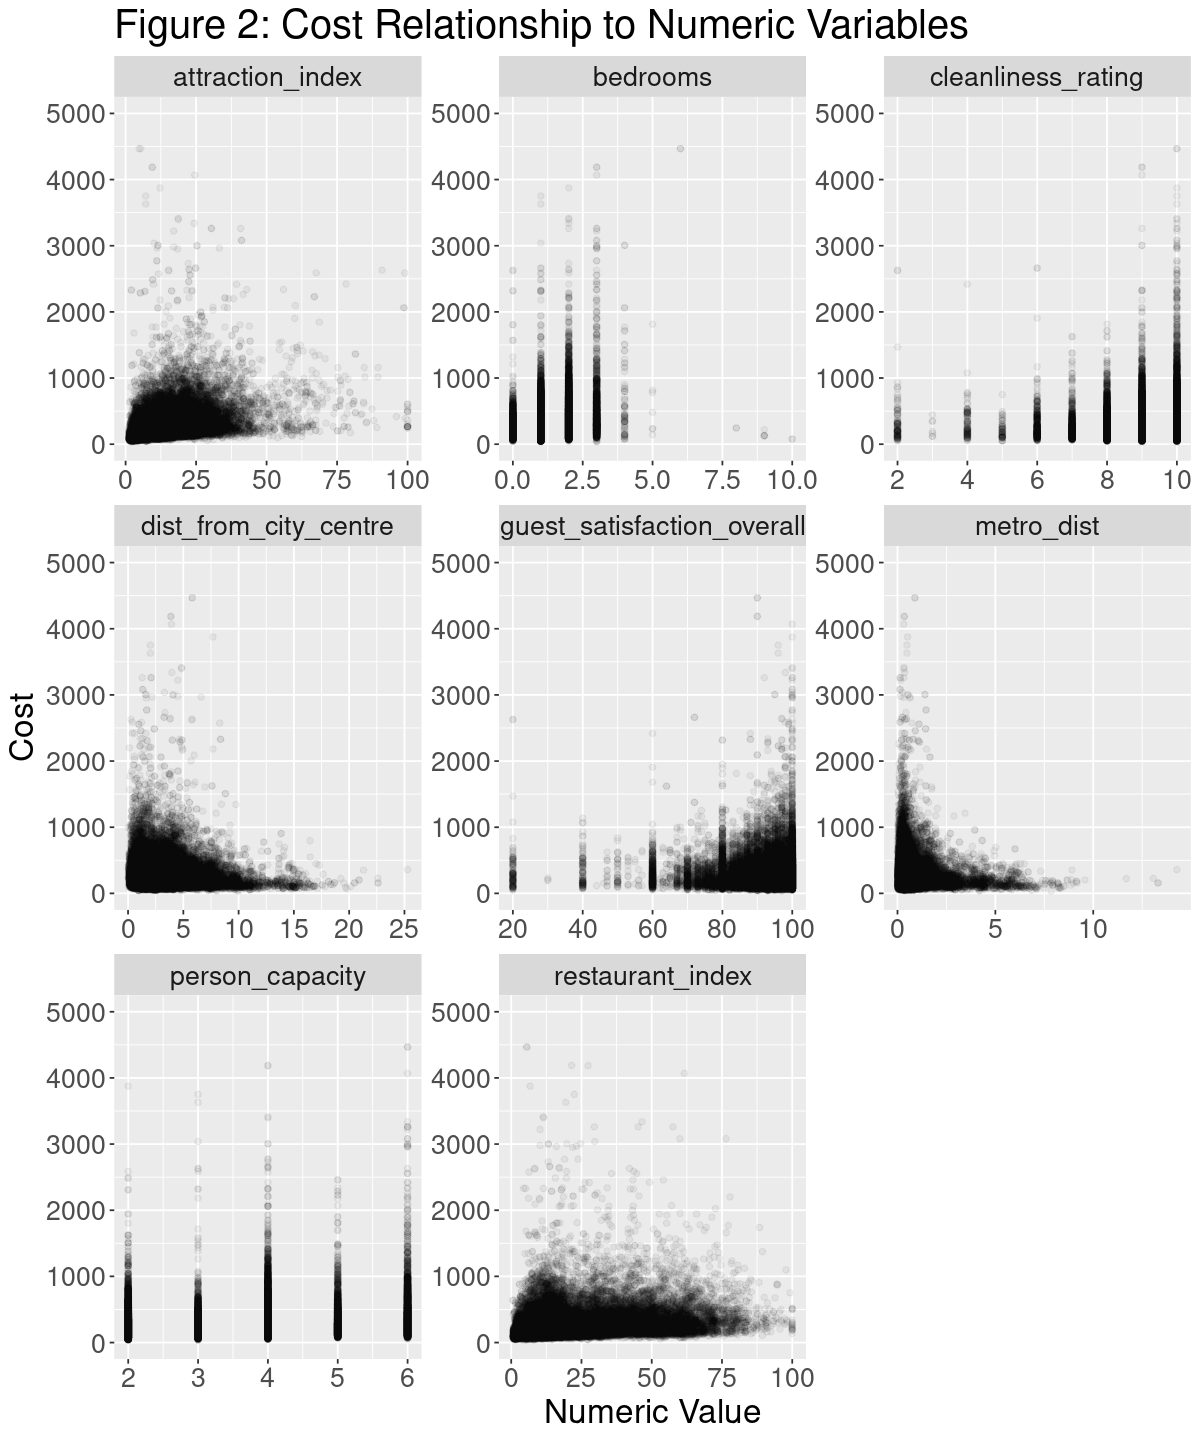

In [19]:
#############################################              #############################################
############################################# TODO CLEANUP #############################################
#############################################              #############################################

options(repr.plot.width = 10, repr.plot.height = 12)

airbnb_numeric <- airbnb_train |>
    select(cost, person_capacity, cleanliness_rating, guest_satisfaction_overall,
           bedrooms, dist_from_city_centre, metro_dist, attraction_index, restaurant_index)

airbnb_numeric |>
    gather(-cost, key = "variable", value = "value") |>
    ggplot(aes(x=value, y = cost)) + 
        geom_point(alpha = 0.05) +
        facet_wrap(~variable, scales = "free", ncol = 3) +
        ylim(0,5000) + # might remove some outliers but could be problematic
        labs(x = "Numeric Value", y = "Cost", title = "Figure 2: Cost Relationship to Numeric Variables") +
        theme(text = element_text(size = 20))

We see that the capacity of an Airbnb listing likely does not have an impact on the price, but a related variable - the number of available bedrooms, has an impact (a moderately strong positive suspected linear distribution) on the price of the listing. There appears to be a strong positive linear (or strictly increasing polynomial) relationship between cost and the cleanliness rating and overall guest satisfaction. This makes sense, as users would likely want clean rooms and an overall good experience. There is a strong negative linear relationship between cost and the distance from the city center and a strong non-linear, likely polynomial or logarithmic relationship between cost and the distance from metro areas. This would suggest that users prefer to be near the city center/metro areas as it is more accessible. Previous findings on lodging accomodations by Ryan (2022) also supports that downtown and urban areas are in higher demand for rooms and lodging for travellers due to the shorter distance to services and various leisure activities. 

There is a slight positive linear relationship between cost and the restaurant/attraction index, but has a fair amount of variance. 

We also see a fair amount of potential outliers in the data, i.e. unusually expensive rooms (typically in the multiple thousands) that may not be close to most of the other values. Under the assumption that those values are outliers, the previous linear relationships would likely hold, however the model will need to account for the fact that those values are outliers as ordinary least squares linear regression is not robust to outliers as the linear models will tend to skew towards the outliers even if the rest of the data follows a perfectly linear ptatern. There are a few ways to handle this: either changing the regression model to weight outliers less in the final model or to remove outliers from the data. We choose the latter option.

There are multiple ways to remove outliers, such as performing some types of clustering algorithms (e.g. density based clustering) and picking points that are not assigned to clusters or training a classification model to detect outliers. However, such methods can be rather slow (especially since our dataset has around 50 thousand entries). Noticing that most of our outliers are prices that are unusually high, we can use a very crude but simple method to remove outliers: we can simply define a cutoff or filter for prices below a certain range. We will return to selecting the cutoff later.

Next, we check colinearity between predictors.

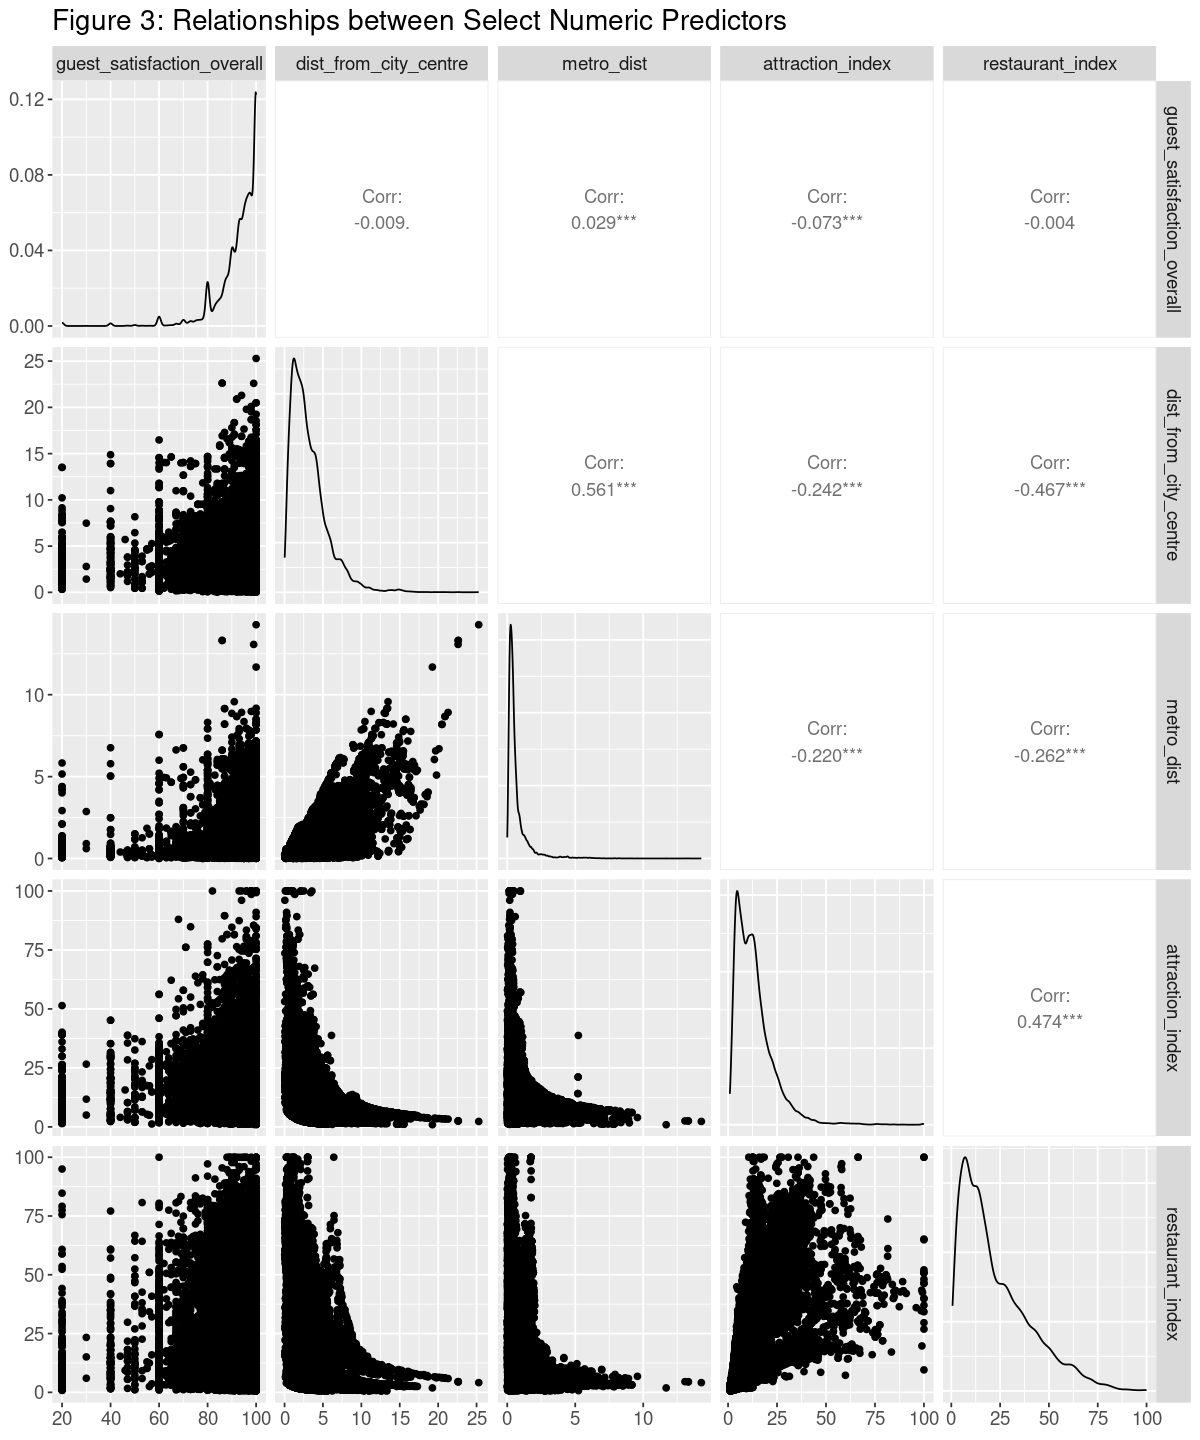

In [18]:
#############################################              #############################################
############################################# TODO CLEANUP #############################################
#############################################              #############################################

options(repr.plot.width = 10, repr.plot.height = 12)

airbnb_sub_numeric <- airbnb_train |>
    select(guest_satisfaction_overall, dist_from_city_centre, metro_dist, attraction_index, restaurant_index)

ggpairs(airbnb_sub_numeric) +
    labs(title = "Figure 3: Relationships between Select Numeric Predictors") +
    theme(text = element_text(size = 14))

Figure 3 indicates possible relationships between predictors, such as a moderately strong linear relationship between the distance from city center and distance from metro areas, or a possible linear relationship between the restaurant index and attraction index. This is further supported by the high correlation coefficients between most variables. We also notice very strong logarithmic or strictly decreasing polynomial relationships between the attraction and restaurant indices and the distances to the city center or metro areas.

<!-- 
I mean technically colinearity is *terrible* and would use something like ridge/lasso regression with something like glmnet...
and also use L1 loss instead of L2 due to outliers

but I don't think we're allowed to do that LOL
-->
Thus, we fit a linear model that would incorporate these parameters: a one-hot encoded representation of relevant categorical variables - city and room type, a linear relationship between guest satisfaction, distance from city center, restaurant and attraction index, number of bedrooms, cleanliness rating and squared distance from metro areas. 

Next, we define the recipe and the linear regression model as previously specified.

In [7]:
#############################################              #############################################
############################################# TODO CLEANUP #############################################
#############################################              #############################################

lm_spec <- linear_reg(mode = "regression", engine = "lm");

lm_recipe <- recipe(cost ~ city + room_type + guest_satisfaction_overall + dist_from_city_centre + metro_dist + attraction_index + restaurant_index, data = airbnb_train) |>
    step_mutate(sqr_metro_dist = (metro_dist**2)) |>
    step_dummy(all_nominal_predictors(), one_hot = TRUE) |>
    # step_lincomb() |>
    step_rm(city_vienna, room_type_Shared.room) # they're linear combinations of the other 2

Now, we return to the choice of cutoff for outliers. We split the training set further into a training and validation set and train multiple models each with a different cutoff. The cutoff will remove values from the training dataset that the linear model uses and we measure the linear model's performance using mean absolute error, as it is more robust to outliers compared to root mean squared error.

<!-- if one of you guys wants to figure out cross-validation without it bricking your PC try it-->

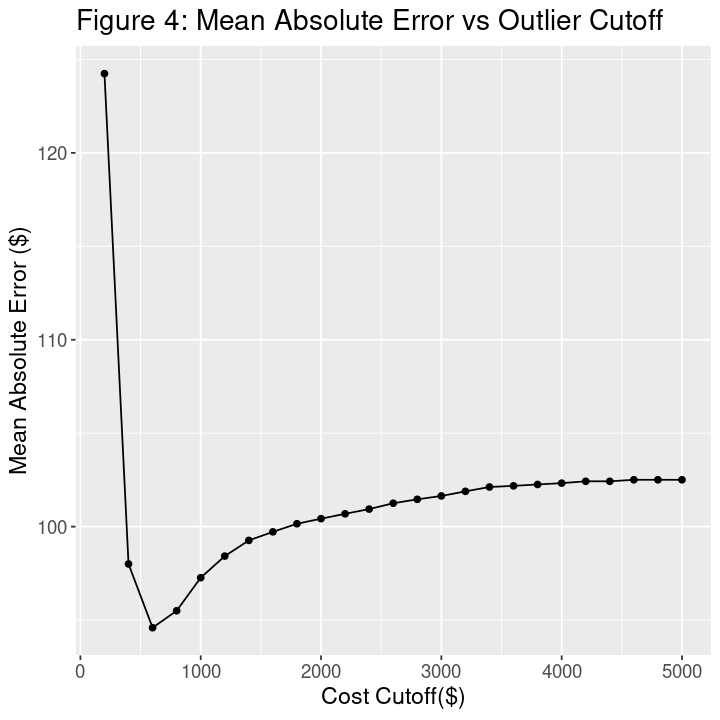

In [13]:
options(repr.plot.width = 6, repr.plot.height = 6)

cutoffs <- tibble(cutoff = seq(200,5000,200));
airbnb_subsplit <- initial_split(airbnb_train, prop = 0.75, strata = room_type)
airbnb_subtrain <- training(airbnb_subsplit)
airbnb_validation <- testing(airbnb_subsplit)

fit.to.valid <- function(cut, train, valid) {
    return(workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(train |> filter(cost < cut)) |>
    predict(valid) |>
    bind_cols(valid) |>
    metrics(truth = cost, estimate = .pred) |>
    filter(.metric == "mae") |>
    select(.estimate) |>
    pull())
}

cutoffs |>
    rowwise() |>
    mutate(mae = fit.to.valid(cutoff, airbnb_subtrain, airbnb_validation)) |>
    ggplot(aes(x = cutoff, y = mae)) +
        geom_line() +
        geom_point() +
        labs(x="Cost Cutoff($)", y = "Mean Absolute Error ($)", title="Figure 4: Mean Absolute Error vs Outlier Cutoff") +
        theme(text = element_text(size=14))

We see that the best cutoff is on the lower end, around 600-1000. We pick the best cutoff, which is around 600. 600 seems reasonable, as the median and mean hovers around 220 and 280 respectively, while the 75th percentile is at 320, so a cutoff of 600 would still keep the vast majority of the data while removing rooms that are unusually expensive. We refit the model on the full dataset and perform the cutoff, counting the number of entries removed.

In [24]:
airbnb_train |>
    filter(cost >= 600) |>
    nrow()

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(airbnb_train |> filter(cost < 600))
lm_fit

[1] 2489

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_mutate()
• step_dummy()
• step_rm()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
               (Intercept)  guest_satisfaction_overall  
                   44.9661                      0.4020  
     dist_from_city_centre                  metro_dist  
                   -1.5325                     -5.7627  
          attraction_index            restaurant_index  
                    2.5812                      0.5871  
            sqr_metro_dist              city_amsterdam  
                    0.4093                    178.5363  
               city_athens              city_barcelona  
                  -93.2724                     55.9691  
               city_b

Note due to a dependency between one-hot encoded variables (as you can determine the last variable given the results of the other remaining values) we remove the last value for each categorical variable, so the coefficients for each one-hot encoded categorical variable would be a change in mean relative to the removed category. For instance, we see `city_london` has a coefficient of $112.7$, which means that the city being London changes the mean by $112.7$ relative to the city being Vienna (the removed variable).

We see considerable variation in the coefficients of the cities: we see that Athens is generally \\$93 cheaper than Vienna, while Amsterdam is on average \\$345 more expensive.

We also see that private rooms are on average \\$34 more expensive than shared rooms, and entire homes are on average \\$209 more expensive.

We also note that the cutoff removed about 5% of the training dataset.

TODO !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
restaurant index is small and might not have an effect (at most $14 affect, but could be from colinearity)
distance from city centre small (due to colinearity)


TODO VISUALIZATION!!!!

calculate prediction error:

In [26]:
lm_test_results <- lm_fit |>
    predict(airbnb_test) |>
    bind_cols(airbnb_test) |>
    metrics(truth = cost, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,323.247779
rsq,standard,0.156351
mae,standard,97.493619


TODO!!!!!

Similarly, we use mean absolute error instead of root mean squared error to evaluate the model. The model seems to predict values with an error of about $97.

Maybe do forward selection?

## Discussion
 - summarize what you found
 - discuss whether this is what you expected to find?
 - discuss what impact could such findings have?
 - discuss what future questions could this lead to?

## References

Gyódi, K. & Nawaro, L. (2021). Determinants of Airbnb prices in European cities: A spatial econometrics approach, Zenodo 
    https://doi.org/10.1016/j.tourman.2021.104319
    
Ryan, B. (2022). Lodging. Community Economic Development. Retrieved April 11, 2023, from   
    https://economicdevelopment.extension.wisc.edu/articles/evaluating-lodging-opportunities/ 

UNWTO (2023). Number of international tourist arrivals worldwide from 2005 to 
    2022, by region (in millions). In Statista. 
    https://www.statista.com/statistics/186743/international-tourist-arrivals-worldwide-by-region-since-2010/

